In [12]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import tkinter

from IPython.display import clear_output

import sys
sys.path.append('..')

import pyro
from samplers import mala, i_sir, ex2_mcmc

from cifar10_experiments.models import Generator, Discriminator

from sampling_utils.adaptive_mc import CISIR, Ex2MCMC, FlowMCMC
from sampling_utils.adaptive_sir_loss import MixKLLoss
from sampling_utils.distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)
from sampling_utils.ebm_sampling import MALA
from sampling_utils.flows import RNVP
from sampling_utils.metrics import ESS, acl_spectrum
from sampling_utils.total_variation import (
    average_total_variation,
)

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
device = 'cpu'
lat_size=100

In [15]:
gen_cifar10 = Generator(lat_size)
gen_cifar10.to(device)

discr_cifar10 = Discriminator()
discr_cifar10.to(device)

prior_cifar10 = torch.distributions.MultivariateNormal(torch.zeros(lat_size).to(device), torch.eye(lat_size).to(device))

In [16]:
gen_cifar10.load_state_dict(torch.load('./weights/generator.pkl', map_location='cpu'))
discr_cifar10.load_state_dict(torch.load('./weights/discriminator.pkl', map_location='cpu'))
gen_cifar10.eval()
discr_cifar10.eval();

In [17]:
def get_energy_wgan(z):
    return (-0.1*discr_cifar10(gen_cifar10(z)).squeeze() - prior_cifar10.log_prob(z).squeeze())

def log_target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    x = torch.FloatTensor(x).to(device)
    return -get_energy_wgan(x).detach().cpu().numpy()

def grad_log_target_dens(x):
    """
    returns the gradient of log-density 
    """
    x = torch.FloatTensor(x).to(device)
    x.requires_grad_(True)
    external_grad = torch.ones(x.shape[0])
    (-get_energy_wgan(x)).backward(gradient=external_grad)
    return x.grad.data.detach().cpu().numpy()

In [18]:
log_target_dens(np.random.randn(2, lat_size))

array([-284.52386, -291.54526], dtype=float32)

In [19]:
grad_log_target_dens(np.random.randn(2, lat_size)).shape

(2, 100)

### Target distribution

In [20]:
class distr:
    """
    Base class for a custom target distribution
    """

    def __init__(self, beta = 1.0):
        super().__init__()
        self.beta = beta

    def log_prob(self, z):
        """
        The method returns target logdensity, estimated at point z
        Input:
        z - datapoint
        Output:
        log_density: log p(z)
        """
        # You should define the class for your custom distribution
        return -get_energy_wgan(z).unsqueeze(0)

    def energy(self, z):
        """
        The method returns target logdensity, estimated at point z
        Input:
        z - datapoint
        Output:
        energy = -log p(z)
        """
        # You should define the class for your custom distribution
        return -get_energy_wgan(z).unsqueeze(0)

    def __call__(self, z):
        return self.log_prob(z)

### Flex2MCMC parameters

In [21]:
params_flex = {
      "N": 5,
      "grad_step": 0.2,
      "adapt_stepsize": False,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_flows": 3, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 5,
      "n_steps": 20,
    }
}

beta = 1.0
scale_proposal = 1.0

target = distr(beta)

loc_proposal = torch.zeros(lat_size).to(device)
scale_proposal = scale_proposal * torch.ones(lat_size).to(device)
proposal = IndependentNormal(
    dim=lat_size,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

In [22]:
pyro.set_rng_seed(42)
mcmc = Ex2MCMC(**params_flex, dim=lat_size)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_flows"], dim=lat_size)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()

flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

100%|██████████| 20/20 [02:57<00:00,  8.89s/it]


In [30]:
#sample from a normalizing flow
n_steps_flex2 = 100
pyro.set_rng_seed(42)
start = proposal.sample((1,))
mcmc.N = 10
mcmc.mala_steps = 1
mcmc.grad_step = 1e-4
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, 1, lat_size)
#sample_flex2_new = sample
#resample with 0 mala steps
#mcmc.mala_steps = 50
#out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)[0]
#out_new = np.array(
#    [_.detach().numpy() for _ in out_new],
#).reshape(-1, batch_size, dim)
#sample_flex2_final = out_new
#print(sample_flex2_final.shape)

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]

tensor([0.])


In [31]:
print(sample.shape)

(100, 1, 100)


100%|██████████| 9/9 [00:43<00:00,  4.84s/it]


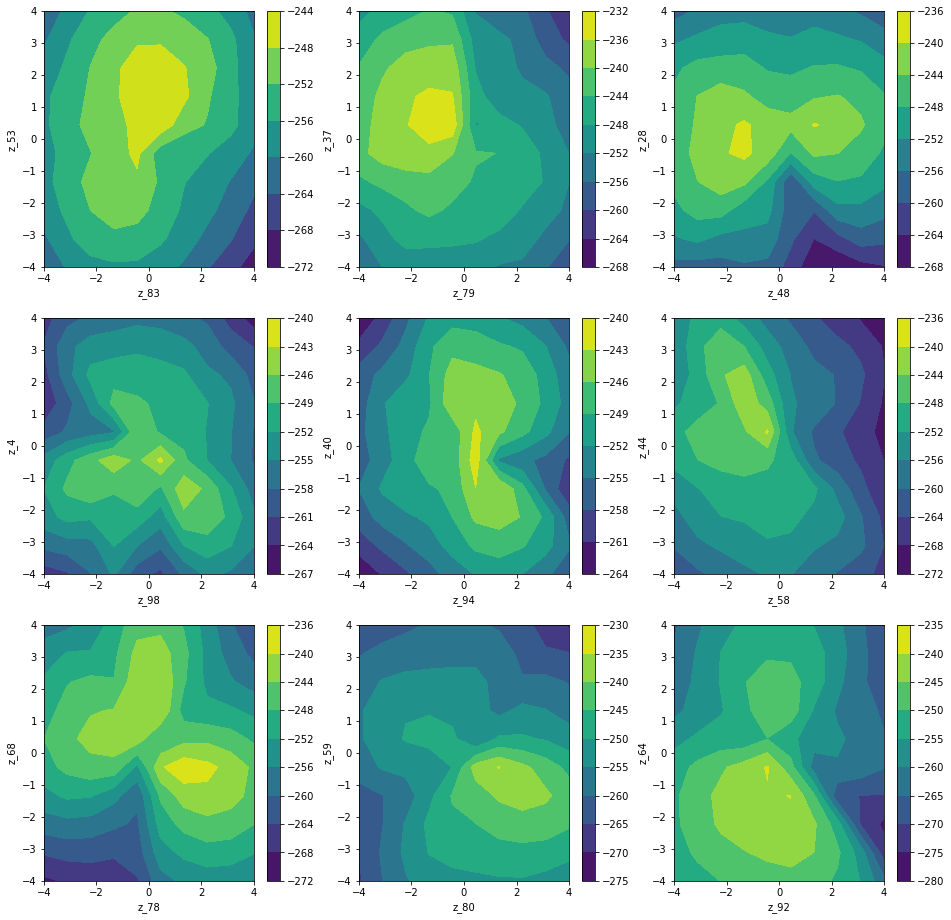

In [27]:
a = 2

plt.figure(figsize=(16, 16))

idxs = []
dens = []

for j in tqdm.tqdm(range(9)):
    idxs_perm = np.random.permutation(np.arange(lat_size))
    
    i1 = idxs_perm[0]
    i2 = idxs_perm[1]
    
    c1 = np.zeros(lat_size)
    c1[i1] = 1

    c2 = np.zeros(lat_size)
    c2[i2] = 1

    idxs.append((i1, i2))
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[:, :, 0] = X
    points[:, :, 1] = Y

    points = points.reshape(-1, 2)

    batch_size = 128

    dens_vals = []
    for i in range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0)):
        z = points[i * batch_size: (i + 1) * batch_size, 0:1] * c1[None, :] + points[i * batch_size: (i + 1) * batch_size, 1:2] * c2[None, :]
        dens_vals.append(log_target_dens(z))

    dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)
    
    dens.append(dens_vals)

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

100%|██████████| 9/9 [00:00<00:00,  9.67it/s]


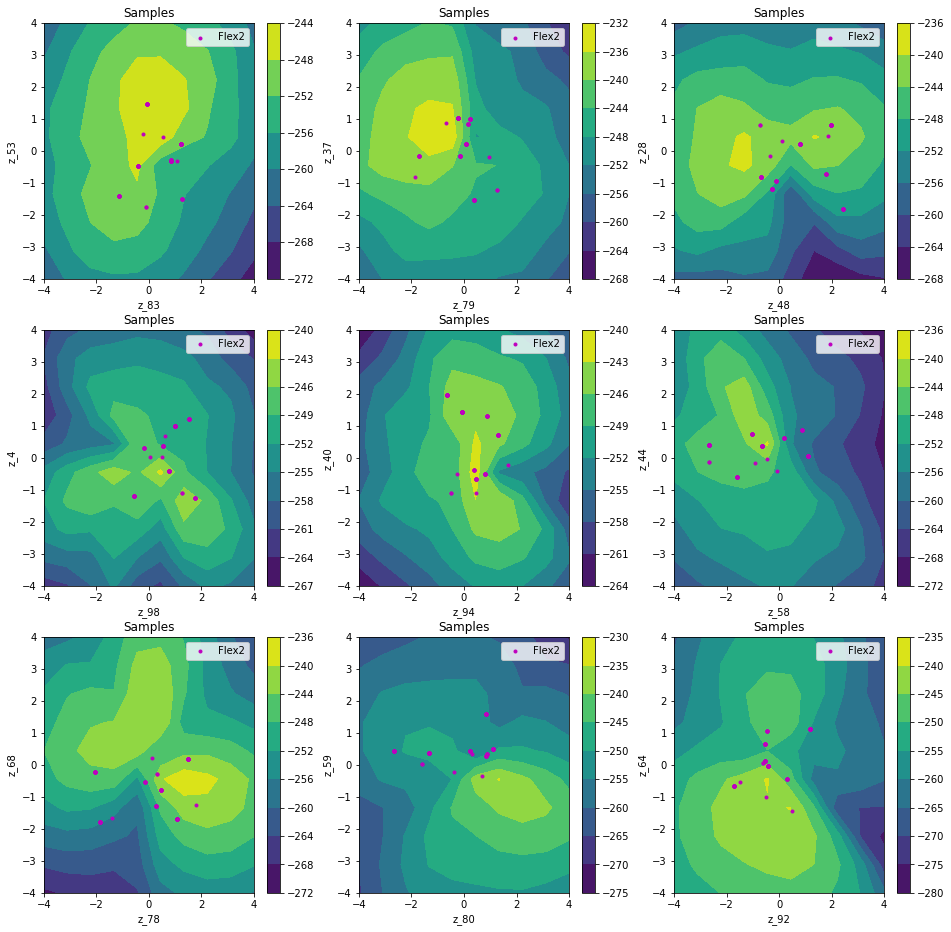

In [28]:
a = 2

plt.figure(figsize=(16, 16))
ind = 1

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    #plt.scatter(Samples_ex2[ind, :, i1], Samples_ex2[ind, :, i2],  c='r', marker='.', label='Ex2MCMC') 
    #plt.scatter(Samples_mala[ind, :, i1], Samples_mala[ind, :, i2], c='b', marker='x', label='MALA')
    #plt.scatter(Samples_isir[ind, :, i1], Samples_isir[ind, :, i2], c='g', marker='^', label='I-SIR')
    plt.scatter(sample[:,0,i1], sample[:,0,i2], c='m', marker='.', label='Flex2')
    plt.legend()
    
    plt.title('Samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')

plt.savefig("flex2_samples_wgan_mala.pdf")
plt.show()

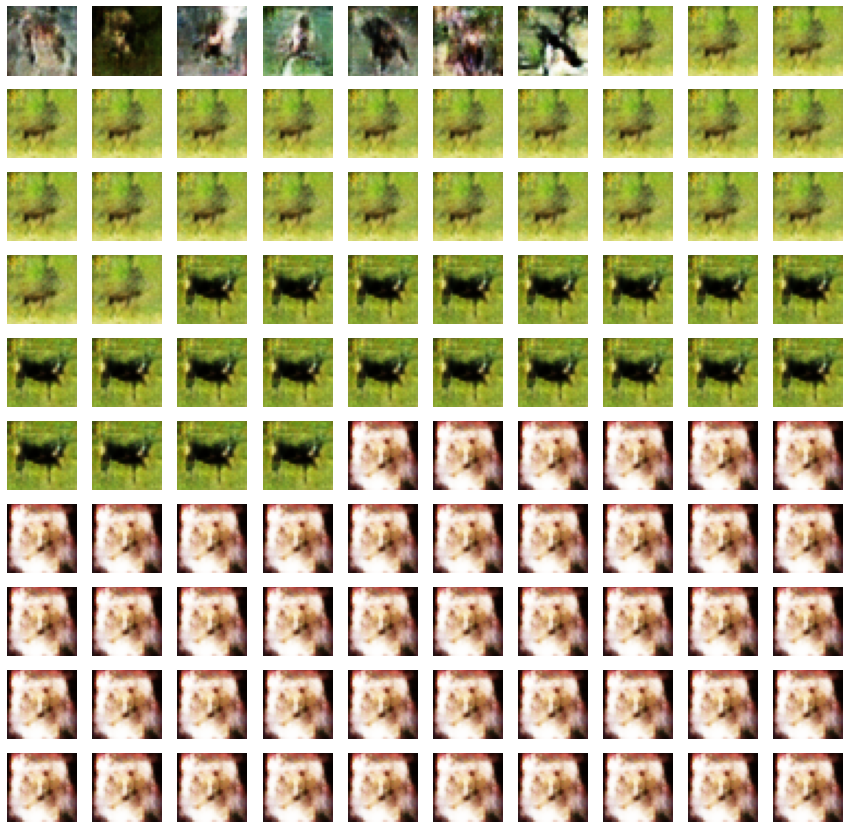

In [33]:
plt.figure(figsize=(15, 15))
ind = 0
sampled = gen_cifar10(torch.FloatTensor(sample[:,0,:]))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    img = sampled[i].detach().cpu().numpy()
    img = (img + 1) / 2
        
    plt.axis('off')
    plt.imshow(img.transpose((1, 2, 0)))

plt.savefig("flex_samples_1_traj_mala.pdf")